In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import timedelta, date
import datetime

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

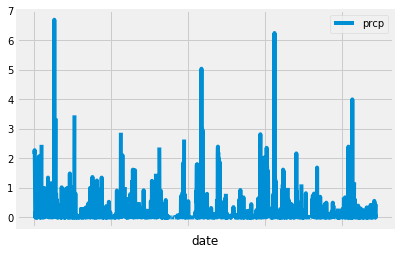

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the latest date available in th database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Convert latest_date string to a date object
date_object = datetime.strptime(str(latest_date), "('%Y-%m-%d',)")

# Calculate the date 1 year ago from the last data point in the database
year_ago = date_object - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame 
scores_pd = pd.DataFrame(scores)

# Sort the dataframe by date and set the index to the date column
sorted_scores_pd = scores_pd.sort_values("date")
sorted_scores_pd.set_index(scores_pd['date'], inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
sorted_scores_pd.plot(x="date", y="prcp")


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_scores_pd.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [12]:
# List the the most active stations and the counts in descending order.
most_active_station = session.query(Measurement.station, func.count(Measurement.id))\
    .group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
    
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

temperature = session.query(*sel).filter((Measurement.station) == most_active_station[0][0]).all()
temperature

[(54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

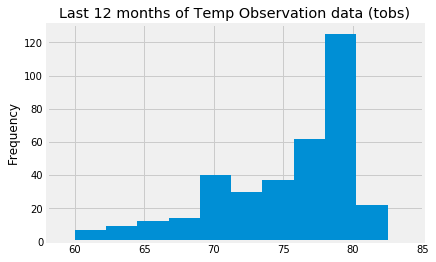

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Count number of temperature observations to get station with a highest number.
results = session.query(Measurement.station, func.count(Measurement.tobs)).\
    filter(Measurement.date > year_ago).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

# Query the station with the highest number of temperature observations
highest_n_temperature = session.query(Measurement.station,Measurement.tobs).\
    filter((Measurement.station) == results[0][0], Measurement.date > year_ago).all()

# Load the query results into a Pandas DataFrame and set index
highest_n_temperature_pd = pd.DataFrame(highest_n_temperature)
highest_n_temperature_pd.set_index(highest_n_temperature_pd["tobs"], inplace=True)

# plot the results as a histogram
highest_n_temperature_pd.hist(bins=12)
plt.title("Last 12 months of Temp Observation data (tobs)")
plt.xlim(58,85)
plt.ylabel("Frequency")

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates and put them in the data frame.
trip_temp = calc_temps('2017-02-10', '2017-02-25')
trip_temp_pd = pd.DataFrame(trip_temp, columns=['tmin', 'tavg', 'tmax'])
trip_temp_pd

,tmin,tavg,tmax
0,61.0,70.887755,80.0


([], <a list of 0 Text xticklabel objects>)

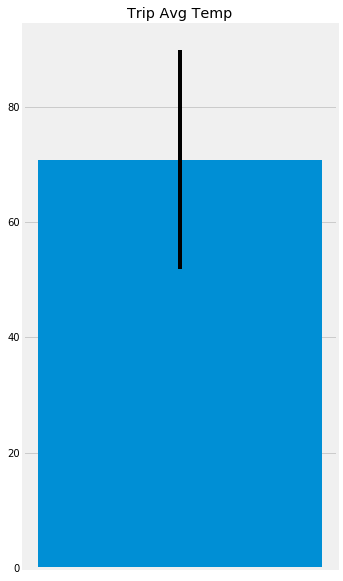

In [27]:
# Plot the results from your previous query as a bar chart. 

#  Use the average temperature for the y value
this_tupple = (trip_temp_pd['tavg'][0])

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_error =  trip_temp_pd["tmax"][0] - trip_temp_pd["tmin"][0]

# Plot bar chart
plt.subplots(figsize=(5, 10))
plt.title("Trip Avg Temp")
plt.bar(x=1,height=this_tupple, yerr=temp_error)
plt.xticks([])


In [28]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, \
           Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
trip_rainfall = session.query(*sel).filter(Measurement.station == Station.station)\
    .filter(Measurement.date > "2017-02-10", Measurement.date < "2017-02-25")\
        .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()


trip_rainfall

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  5.9799999999999995),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.83),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  5.739999999999998),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  5.09),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  3.2599999999999993),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  3.1399999999999997),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.17)]

## Optional Challenge Assignment

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [57]:
# Use the start and end date to create a range of dates
date1 = '2017-02-10'
date2 = '2017-02-16'
mydates = pd.date_range(date1, date2).tolist()

# Use mydates list to put dates in the format required for dataftame 
date_list = []
count = 0
for date_value in mydates:
    date_list.append(f"{mydates[count].year}-0{mydates[count].month}-{mydates[count].day}")
    count += 1
    
# Create a dataframe that will be later used in the chart    
date_for_df =pd.DataFrame(date_list, columns=['date'])

# Stip off the year and save a list of %m-%d strings for future use in daily_normals()
normals_dates = []
count = 0
for i in mydates:
    normals_dates.append(f"0{mydates[count].month}-{mydates[count].day}")
    count += 1
    
# Loop through the list of %m-%d strings and calculate the daily normals
normals=[]
count = 0
for date_item in normals_dates:
    normals.append(daily_normals(date_item)[0])
    count += 1

normals

[(56.0, 68.41666666666667, 76.0),
 (61.0, 69.25, 79.0),
 (60.0, 69.15789473684211, 78.0),
 (58.0, 70.36206896551724, 80.0),
 (62.0, 70.89473684210526, 79.0),
 (56.0, 70.28813559322033, 79.0),
 (59.0, 70.48214285714286, 76.0)]

In [58]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temp_pd = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_temp_pd["date"] = date_for_df

trip_temp_pd.set_index(trip_temp_pd["date"], inplace=True)
trip_temp_pd.head()

,tmin,tavg,tmax,date
date,,,,
2017-02-10,56.0,68.416667,76.0,2017-02-10
2017-02-11,61.0,69.250000,79.0,2017-02-11
2017-02-12,60.0,69.157895,78.0,2017-02-12
2017-02-13,58.0,70.362069,80.0,2017-02-13
2017-02-14,62.0,70.894737,79.0,2017-02-14


[Text(0, 0, '2017-02-10'),
 Text(0, 0, '2017-02-11'),
 Text(0, 0, '2017-02-12'),
 Text(0, 0, '2017-02-13'),
 Text(0, 0, '2017-02-14'),
 Text(0, 0, '2017-02-15'),
 Text(0, 0, '2017-02-16')]

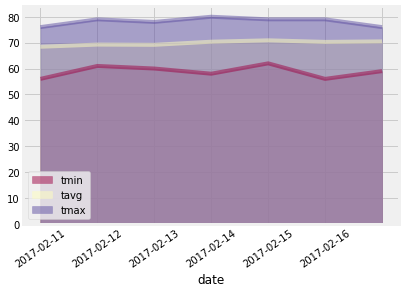

In [61]:
# Plot the daily normals as an area plot with `stacked=False`
ax = trip_temp_pd.plot(kind='area', stacked=False, alpha=0.5, colormap='Spectral')
ax.set_xticklabels(trip_temp_pd['date'], rotation=35)
